In [2]:
%cd content 
!git clone https://github.com/dmitsf/GOT 
%cd GOT/got/taxonomies/
!pip3 install --upgrade ete3
import ete3_functions, taxonomy
%cd /Users/veronikalebedyuk/Desktop/content

[Errno 2] No such file or directory: 'content'
/Users/veronikalebedyuk/Desktop/content
fatal: destination path 'GOT' already exists and is not an empty directory.
/Users/veronikalebedyuk/Desktop/content/GOT/got/taxonomies
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
/Users/veronikalebedyuk/Desktop/content


### Вспомогательные функции для вывода данных 

In [628]:
def show_scores(x, rows, cols, scores, p, title, figsize=(20,10),labels= None):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=figsize)
    plt.suptitle(title)
    
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        for j in range(len(scores)):
            y = scores[j][i, :]
            if labels:
                plt.plot(x,y, label=labels[j])
                plt.legend(loc="upper left")
            else:
                plt.plot(x,y)
        plt.ylim(0,1)
        plt.axhline(y = p[i], color = 'r', linestyle = '--',label='expected')
        plt.legend(loc="upper left")
        plt.title("p = {:.2f}".format(p[i]))
        plt.xlabel('taxonomy size')
        plt.ylabel('score')
    plt.show()

In [721]:
from ete3 import Tree, faces, AttrFace,TextFace, TreeStyle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def my_layout(node):
    if node.is_leaf():
        # If terminal node, draws its name
        name_face = AttrFace("name")
    else:
        # If internal node, draws label with smaller font size
        name_face = AttrFace("name", fsize=10)
    # Adds the name face to the image at the preferred position
    faces.add_face_to_node(name_face, node, column=0, position="branch-right")
    
def depth_layout(node):
    if node.is_leaf():
        # If terminal node, draws its name
        name_face = AttrFace("name")
        depth_face = AttrFace("depth",fgcolor='#FF0000', fsize=5)
    else:
        # If internal node, draws label with smaller font size
        name_face = AttrFace("name")
        depth_face = AttrFace("depth",fgcolor='#FF0000', fsize=5)
        
    # Adds the name face to the image at the preferred position
    faces.add_face_to_node(name_face, node, column=0, position="branch-right")
    faces.add_face_to_node(depth_face, node, column=1, position="branch-right")
    
def loose_map_layout(node):
    if node.is_leaf():
        # If terminal node, draws its name
        name_face = AttrFace("name")
        if node.name != (node.loose_map).name:
            name_face = TextFace((node.loose_map).name, fsize=10,fgcolor='#FF0000')
        elif node.depth != (node.loose_map).depth:
            name_face = TextFace((node.loose_map).name, fsize=10,fgcolor='#EE6AA7')
    else:
        # If internal node, draws label with smaller font size
        name_face = AttrFace("name", fsize=10)
        if node.name != (node.loose_map).name:
            name_face = TextFace((node.loose_map).name, fsize=10,fgcolor='#FF0000')
        elif node.depth != (node.loose_map).depth:
            name_face = TextFace((node.loose_map).name, fsize=10,fgcolor='#EE6AA7')
        
    # Adds the name face to the image at the preferred position
    
    faces.add_face_to_node(name_face, node, column=0, position="branch-right")

def strict_map_layout(node):
    if node.is_leaf():
        # If terminal node, draws its name
        name_face = AttrFace("name")
        if node.name != (node.strict_map).name:
            name_face = TextFace((node.strict_map).name, fsize=10,fgcolor='#FF0000')
    else:
        # If internal node, draws label with smaller font size
        name_face = AttrFace("name", fsize=10)
        if node.name != (node.strict_map).name:
            name_face = TextFace((node.strict_map).name, fsize=10,fgcolor='#FF0000')
        
    # Adds the name face to the image at the preferred position
    faces.add_face_to_node(name_face, node, column=0, position="branch-right")

def show_together(tree1, tree2, layout1=my_layout,layout2=my_layout):
    ts = TreeStyle()
    # Do not add leaf names automatically
    ts.show_leaf_name = False
    # Use my custom layout
    ts.scale = 5

    ts.layout_fn = layout1
    tree1.render("original.png", w=183, units="mm",tree_style=ts)
    ts.layout_fn = layout2
    tree2.render("modified.png", w=183, units="mm",tree_style=ts)

    # create figure
    fig = plt.figure(figsize=(20, 10))

    # setting values to rows and column variables
    rows = 1
    columns = 2

    # reading images
    Image1 =  mpimg.imread('original.png')
    Image2 =  mpimg.imread('modified.png')

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)
    fig.tight_layout()

    # showing image
    plt.imshow(Image1)
    plt.axis('off')
    plt.title("original")

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    # showing image
    plt.imshow(Image2)
    plt.axis('off')
    plt.title("modified")

## реализация strict и loose mapping

In [722]:

def strict_mapping(tree1, tree2,feature='depth'):
    def no_perfect_match(node): #функция для остановки обхода tree1 на вершинах без полного анаога в tree2
        if 'strict_map' in node.features:
            return not (node.name == (node.strict_map).name and getattr(node,feature) == getattr(node.strict_map,feature))

        matched = tree2.search_nodes(name=node.name) 
        node.add_features(strict_map=None)
        if not matched: #проверяем имя
              return True
        if getattr(matched[0],feature) != getattr(node,feature): #проверяем rk(node)
              return True
        node.strict_map=matched[0]
        return False
    
    for node in tree1.traverse("preorder",is_leaf_fn=no_perfect_match):
        if no_perfect_match(node):
            node.strict_map = node.up.strict_map
            for des in node.traverse():
                des.add_features(strict_map=node.up.strict_map)
                
def strict_mapping_dissimilarity_pct(tree1, tree2,feature='depth', debug=False):
    #функция считающая расстояние между таксономиями как процент несоотвествия вершин после strict mapping
    strict_mapping(tree1, tree2,feature)
    score = 0
    total = 0
    for node in tree1.traverse():
        score+= node.name == (node.strict_map).name and getattr(node,feature) == getattr(node.strict_map,feature)
        total+=1
        if debug:
            print(node.name, getattr(node,feature), '-----',node.strict_map.name,getattr(node.strict_map,feature))
        node.del_feature('strict_map')
    
    return 1 - score/total

def strict_mapping_dissimilarity_score(tree1, tree2,feature='depth', debug=False):
    #функция считающая расстояние между таксономиями как нормированная разница величин в вершинах после strict mapping
    strict_mapping(tree1, tree2, feature)
    score = 0
    total = 0
    for node in tree1.traverse():
        score+=abs(getattr(node,feature)-getattr(node.strict_map,feature))
        total+=getattr(node,feature) + getattr(node.strict_map,feature)
        if debug:
            print(node.name, getattr(node,feature), '-----',node.strict_map.name,getattr(node.strict_map,feature))
        node.del_feature('strict_map')
    return score/total


In [737]:
def loose_mapping(tree1, tree2, feature='depth'):
    for node in tree1.traverse("preorder"):
        matched = tree2.search_nodes(name=node.name)
        if not matched:
            node.add_features(loose_map=node.up.loose_map)
        elif getattr(matched[0],feature) != getattr(node,feature) and not node.is_root():
            node.add_features(loose_map=node.up.loose_map)
        else:
            node.add_features(loose_map=matched[0])
            
def loose_mapping_dissimilarity_pct(tree1, tree2,feature='depth'):
    #функция считающая расстояние между таксономиями как процент несоотвествия вершин после loose mapping
    loose_mapping(tree1, tree2,feature)
    score = 0
    total = 0
    for node in tree1.traverse():
        score+=node.name == (node.loose_map).name and getattr(node,feature)==getattr(node.loose_map,feature)
        total+=1
        node.del_feature('loose_map')
    return 1- score/total
            
def loose_mapping_dissimilarity_score(tree1, tree2,feature='depth',debug=False):
    #функция считающая расстояние между таксономиями как нормированная разница величин в вершинах после loose mapping
    loose_mapping(tree1, tree2, feature)
    score = 0
    total = 0
    for node in tree1.traverse():
        score+=abs(getattr(node,feature)-getattr(node.loose_map,feature))
        total+=getattr(node,feature)+getattr(node.loose_map,feature)
        if debug:
            print(node.name, getattr(node,feature), '-----',node.loose_map.name,getattr(node.loose_map,feature))
        node.del_feature('loose_map')
    return score/total

In [738]:
def add_depth(tree):
    for node in tree.traverse():
        if node.is_root():
            tree.add_features(leaves_depth=0)
            tree.add_features(leaves_cnt=0)
            tree.add_features(depth=0)
            continue
        node.add_features(depth=node.up.depth + 1)
        if node.is_leaf():
            tree.leaves_depth+=node.depth
            tree.leaves_cnt+=1

In [739]:
def add_subtree_size(tree):
    norm = len([tree.traverse()])
    for node in tree.traverse('postorder'):
        node.add_features(subtree_size=1)
        for child in node.get_children():
            node.subtree_size+=child.subtree_size/norm

Демонстрация работы методов сопоставления вершин

In [740]:
trees = []
trees.append(Tree(ete3_functions.make_ete3_raw(taxonomy.Taxonomy("./taxonomy_example_1.csv")), format=1))
trees.append(Tree(ete3_functions.make_ete3_raw(taxonomy.Taxonomy("./taxonomy_example_2.csv")), format=1))
trees.append(Tree(ete3_functions.make_ete3_raw(taxonomy.Taxonomy("./taxonomy_example_3.csv")), format=1))
for t in trees:
    add_subtree_size(t)
    add_depth(t)

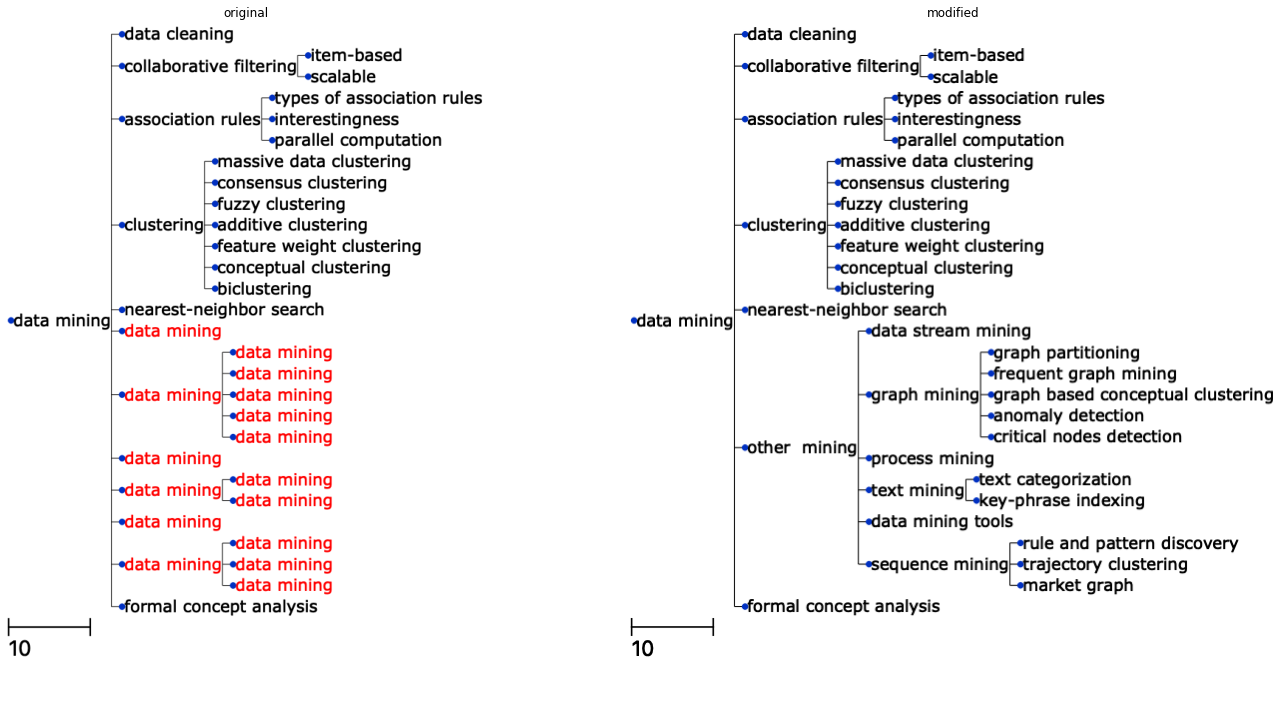

In [747]:
strict_mapping(trees[0],trees[1])
show_together(trees[0],trees[1],layout1=strict_map_layout)

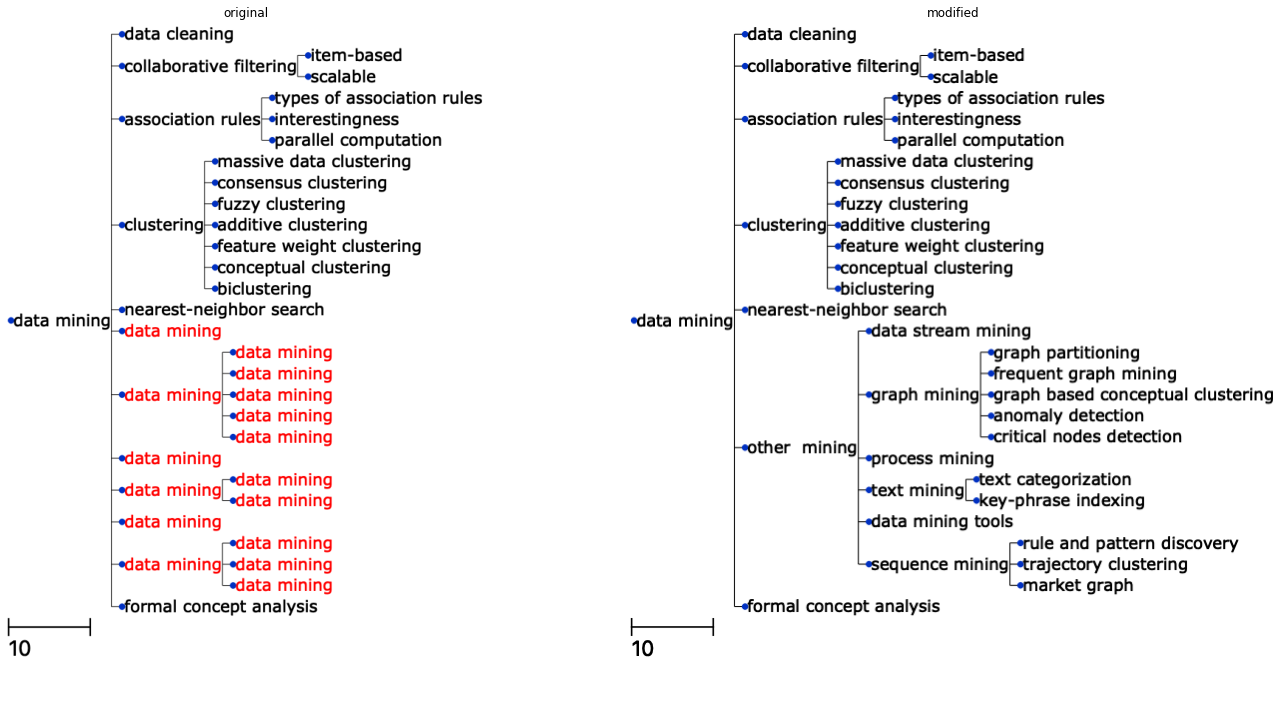

In [746]:
loose_mapping(trees[0],trees[1])
show_together(trees[0],trees[1],layout1=loose_map_layout)

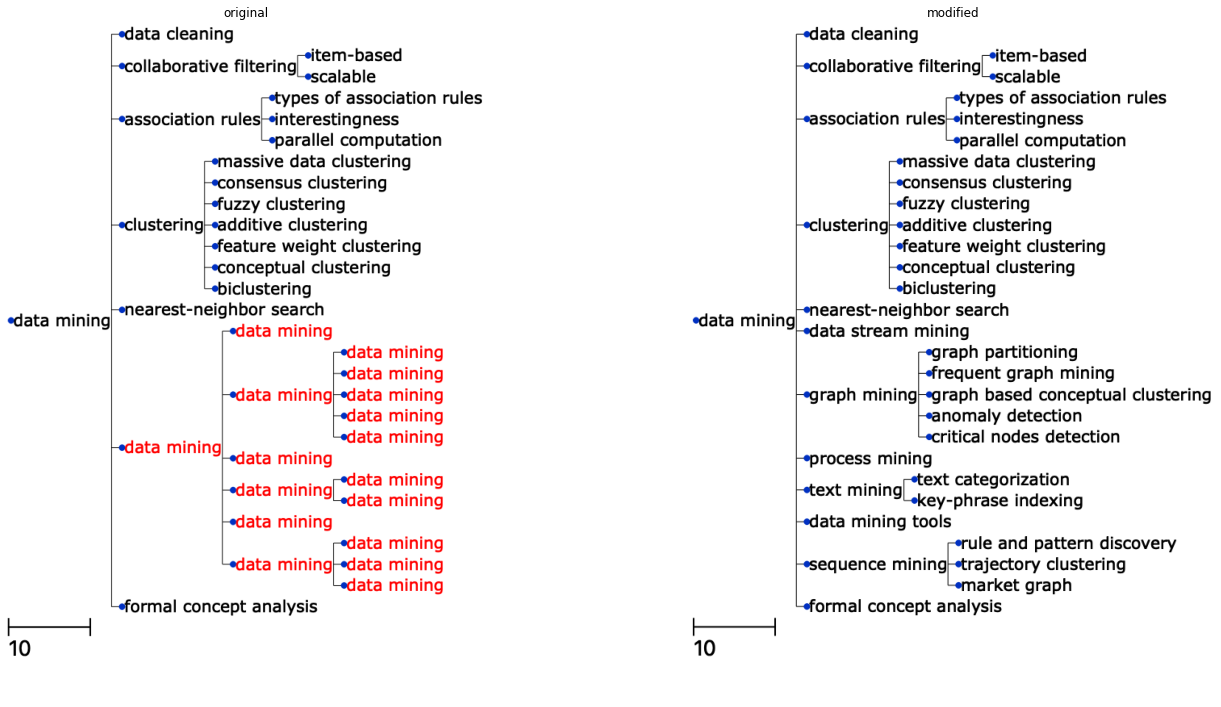

In [748]:
loose_mapping(trees[1],trees[0])
show_together(trees[1],trees[0],layout1=loose_map_layout)

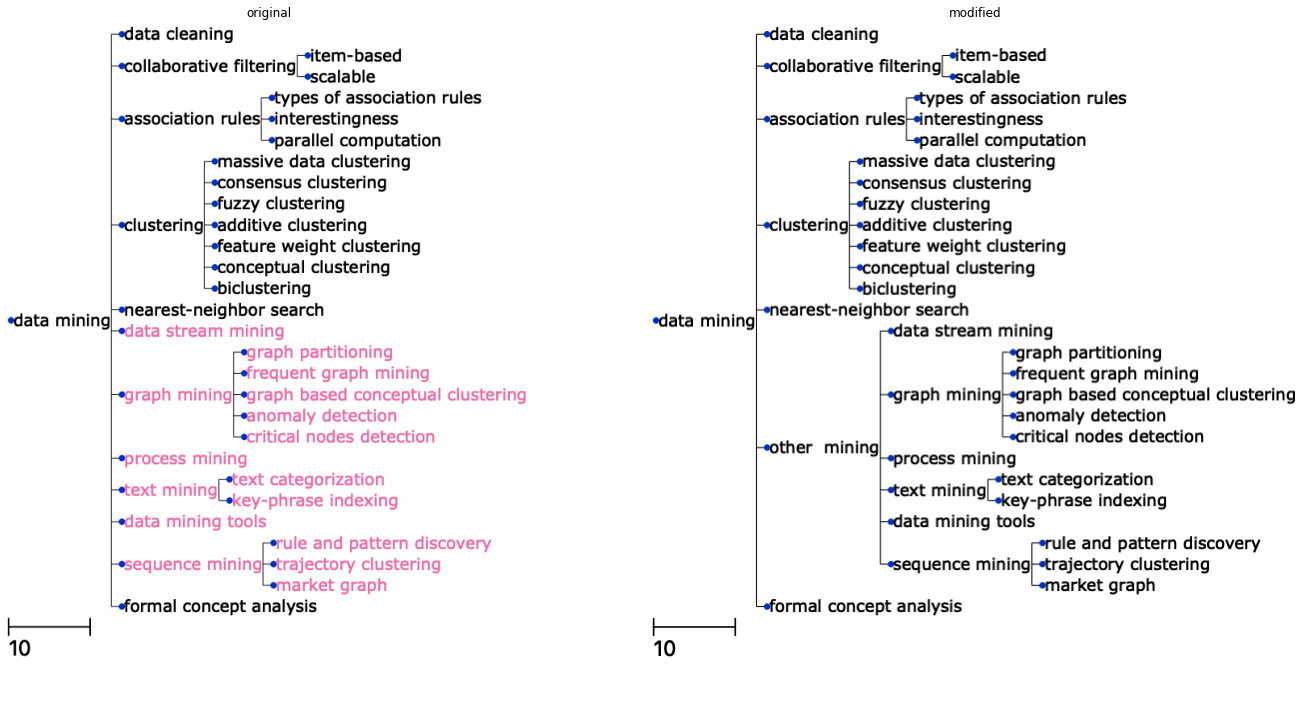

In [749]:
loose_mapping(trees[0],trees[1],'subtree_size')
show_together(trees[0],trees[1],layout1=loose_map_layout)

### Методы генерации и модификации случайных таксономий

In [689]:
import random
random.seed(42)

def split(tree, K):
    if len(tree)<=1:
        return tree
    if len(tree)==2:
        return [[tree[0]],[tree[1]]]
    m = random.randint(2, K)
    res = [[] for i in range(m)]
    for i in range(len(tree)):
        res[random.randint(0, m-1)].append(tree[i])
    for i in range(len(res)):
        res[i] = split(res[i],K)
    #res[i] = sorted(split(res[i],K),key=lambda x: x[0])
    res = list(filter(lambda a: a != [], res))
    return res

def generate(N,K):
    I = list(range(0, N))
    t = split(I, K)
    return t
def ete_tree_string(tree,first=True, name = '0.'):
    if len(tree)==0:
        return name
    if type(tree[0]) is not list:
        return str(tree[0])
    ans = '('
    for i in range(len(tree)):
        if ans[-1]!='(':
            ans+=','
        ans+=ete_tree_string(tree[i],False,name+str(i)+'.')
    if ans[-1]=='(':
        return '';
    ans += ')'
    ans += name
    if first:
        ans+=';'
    return ans

def ete_tree(tree):
    ete_tree = Tree(ete_tree_string(tree), format=1)
    for parent in ete_tree.traverse():
        children = sorted(parent.get_children(),key=lambda x: x.detach().name)
        for child in children:
            parent.add_child(child)
    add_depth(ete_tree)
    add_subtree_size(ete_tree)
    return ete_tree

In [690]:
def modify_ete_tree(etetree, p, debug=False):
    modify=[]
    new_tree = copy.deepcopy(etetree)
    leaves = new_tree.get_leaves()
    N = len(leaves)
    for i in range(N):
        r = random.randint(0, 100)
        if r <= p:
            modify.append(leaves[i].detach())
    if debug:
        print([leaf.name for leaf in modify])
    all_nodes = list(new_tree.traverse())
    for leaf in modify:
        parent = all_nodes[random.randint(0, len(all_nodes)-1)]
        parent.add_child(leaf)
        children = sorted(parent.get_children(),key=lambda x: x.detach().name)
        for child in children:
            parent.add_child(child)
    add_depth(new_tree)
    add_subtree_size(new_tree)
    return new_tree

## Рассчеты расстояний, использующие strict mapping

In [691]:
import numpy as np
import time
import copy

In [692]:
def get_dists(k, dist_func, param = None):
    base_trees = [ete_tree(generate(x,x//10)) for x in range(100,500,50)] 
    scores = np.zeros((6,len(range(100,500,50))))
    for p in range(1,60,10):
        start = time.time()
        for i in range(k):
            if param:
                scores[p//10,:]+= np.array([dist_func(t, modify_ete_tree(t,p),param) for t in base_trees])
            else:
                scores[p//10,:]+= np.array([dist_func(t, modify_ete_tree(t,p)) for t in base_trees])
        scores[p//10,:]/=k
        end = time.time()
        print(f'p={p},average={scores[p//10,:][:5]} calculation time', end - start)
    return scores

In [693]:
scores_sm_depth_pct = get_dists(10,strict_mapping_dissimilarity_pct)

p=1,average=[0.01096774 0.01013825 0.00797101 0.00707965 0.01004902] calculation time 10.582726001739502
p=11,average=[0.05096774 0.06129032 0.06413043 0.05840708 0.06127451] calculation time 10.56284785270691
p=21,average=[0.09806452 0.10276498 0.09818841 0.12094395 0.10784314] calculation time 10.86756682395935
p=31,average=[0.14451613 0.14930876 0.16884058 0.15014749 0.14926471] calculation time 11.689743041992188
p=41,average=[0.19354839 0.18018433 0.21050725 0.19705015 0.19705882] calculation time 11.435983180999756
p=51,average=[0.24193548 0.23271889 0.2557971  0.24542773 0.25073529] calculation time 10.9063880443573


In [694]:
scores_sm_subtree_pct = get_dists(10,strict_mapping_dissimilarity_pct, 'subtree_size')

p=1,average=[0.34210526 0.33393665 0.54695946 0.39312321 0.68997555] calculation time 5.605051040649414
p=11,average=[0.79210526 0.8760181  0.89831081 0.83438395 0.9606357 ] calculation time 2.342305898666382
p=21,average=[0.92171053 0.91674208 0.97837838 0.9034384  0.94914425] calculation time 2.3394758701324463
p=31,average=[0.95131579 0.93936652 0.96216216 0.94670487 0.97775061] calculation time 1.707996129989624
p=41,average=[0.97631579 0.96561086 0.97364865 0.95415473 0.98141809] calculation time 1.6898210048675537
p=51,average=[0.95855263 0.94479638 0.98986486 0.97507163 0.97726161] calculation time 1.6566388607025146


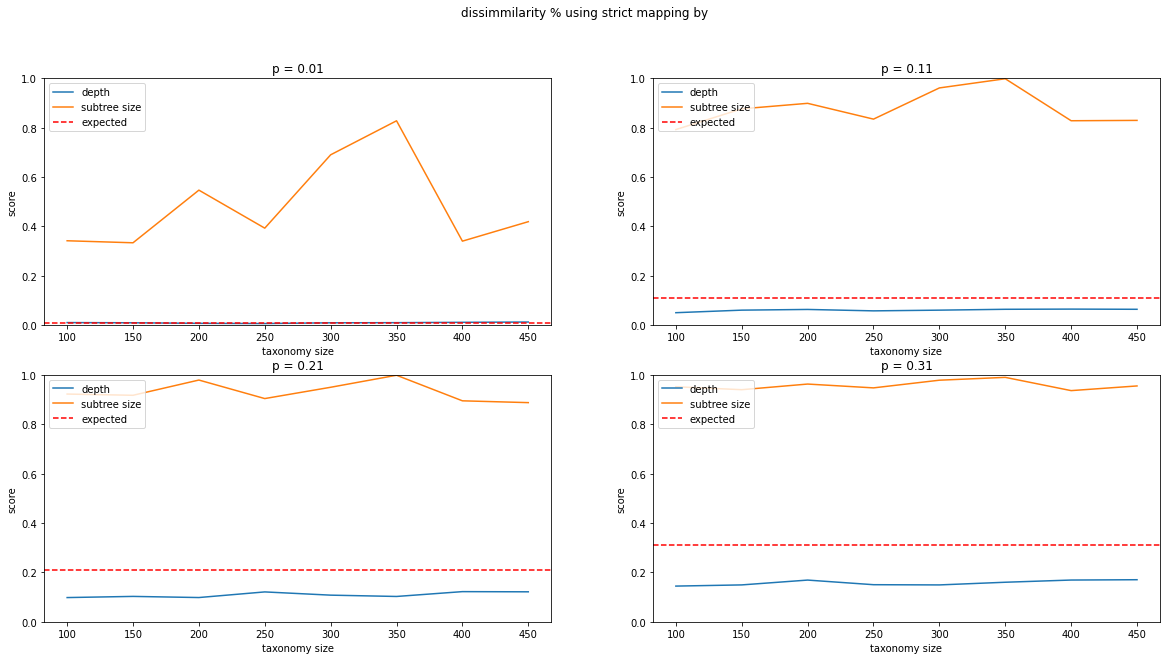

In [695]:
x = [i for i in range(100,500,50)]
p = [0.01 + i*0.1 for i in range(6)]
show_scores(x, 2, 2, [scores_sm_depth_pct, scores_sm_subtree_pct], p, 'dissimmilarity % using strict mapping by', labels=['depth','subtree size'],figsize=(20,10))

In [696]:
scores_sm_depth_ds = get_dists(10,strict_mapping_dissimilarity_score)

p=1,average=[0.00227337 0.00230875 0.00115273 0.0017811  0.00153739] calculation time 11.031441926956177
p=11,average=[0.01237596 0.01065025 0.00978305 0.01128586 0.00815744] calculation time 10.897071838378906
p=21,average=[0.01836118 0.02106891 0.01982889 0.01835557 0.0156203 ] calculation time 10.338168859481812
p=31,average=[0.02892418 0.03048416 0.02641278 0.02780307 0.02264817] calculation time 10.397037029266357
p=41,average=[0.03606045 0.04186605 0.03763012 0.03861289 0.03236922] calculation time 10.742433071136475
p=51,average=[0.04782571 0.04767927 0.04644037 0.04553094 0.03737995] calculation time 10.45445704460144


In [697]:
scores_sm_subtree_ds = get_dists(10,strict_mapping_dissimilarity_score, 'subtree_size')

p=1,average=[0.62087187 0.82275216 0.95791411 0.94022092 0.971802  ] calculation time 4.95738410949707
p=11,average=[0.93817138 0.95024202 0.96350875 0.97258721 0.97997789] calculation time 2.5301918983459473
p=21,average=[0.94361529 0.95358415 0.96986244 0.97525195 0.97785546] calculation time 1.9395856857299805
p=31,average=[0.93940719 0.95916744 0.96988411 0.97752497 0.97969757] calculation time 1.7611210346221924
p=41,average=[0.94486232 0.95646456 0.96881827 0.97590886 0.97868332] calculation time 1.6052918434143066
p=51,average=[0.94061365 0.95783538 0.97059306 0.97676738 0.98136231] calculation time 1.8811089992523193


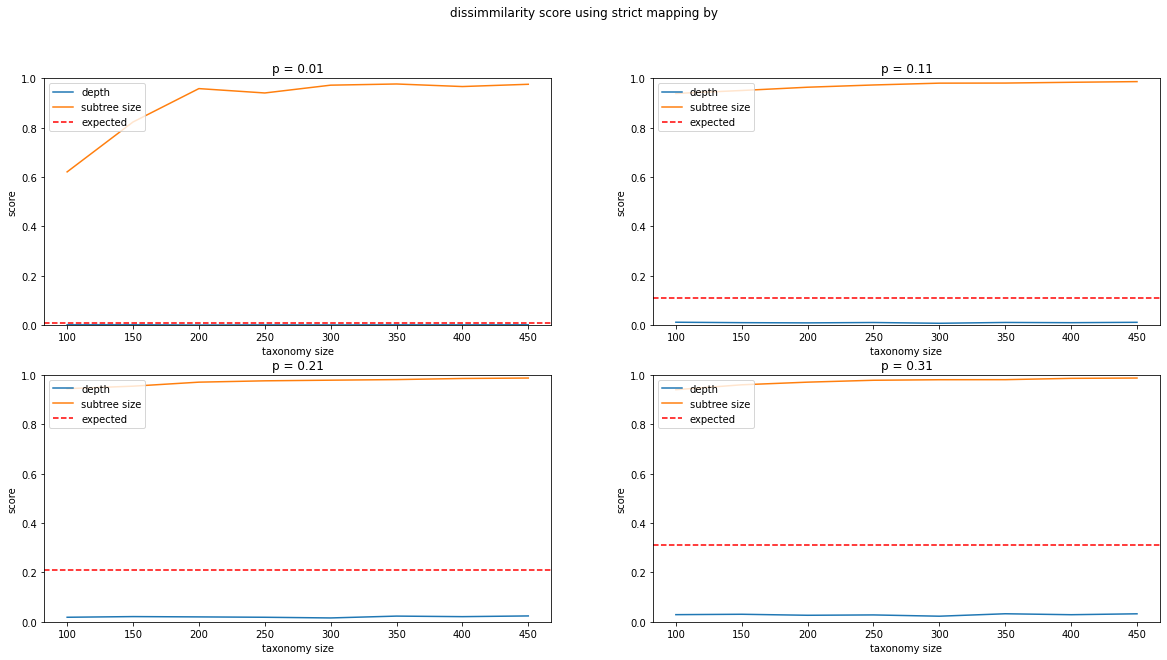

In [698]:
x = [i for i in range(100,500,50)]
p = [0.01 + i*0.1 for i in range(6)]
show_scores(x, 2, 2, [scores_sm_depth_ds, scores_sm_subtree_ds], p, 'dissimmilarity score using strict mapping by', labels=['depth','subtree size'],figsize=(20,10))

## Расчет расстояний между листьями

In [699]:
def char_vector(tree):
    d1 = []
    leaves = list(tree.get_leaves())
    for i in range(len(leaves)-1):
        d1.append(leaves[i].get_distance(leaves[i+1]))
    return d1

In [679]:
import math
def norm2(v):
    return math.sqrt(sum([x*x for x in v]))
def leaves_distance_pct(tree1, tree2):
    dist = 0
    norm = 0
    d1 = char_vector(tree1)
    d2 = char_vector(tree2)
    if len(d2)<len(d1):
        d2+=[0]*(len(d1)-len(d2))
    for i in range(len(d1)):
        dist+=abs(d1[i] - d2[i])
        norm += d1[i]+d2[i]
    return dist/norm

In [680]:
k = 10
base_trees = [ete_tree(generate(x,x//10)) for x in range(100,500,50)] 
scores = np.zeros((6,len(range(100,500,50))))

for p in range(1,60,10):
    start = time.time()
    for i in range(k):
        scores[p//10,:]+= np.array([leaves_distance_pct(t, modify_ete_tree(t,p)) for t in base_trees])
    scores[p//10,:]/=k
    end = time.time()
    print(f'p={p},average={scores[p//10,:][:5]} calculation time', end - start)

p=1,average=[0.17366667 0.13464203 0.16594966 0.18052222 0.17361968] calculation time 1.5399060249328613
p=11,average=[0.24958695 0.24373527 0.23993294 0.24291891 0.23482784] calculation time 1.2753281593322754
p=21,average=[0.2729892  0.27243115 0.27101139 0.26889489 0.25891606] calculation time 1.3307819366455078
p=31,average=[0.28388473 0.30107131 0.29373383 0.29111842 0.28202052] calculation time 1.577739953994751
p=41,average=[0.30103446 0.29825317 0.29929556 0.28600167 0.29896778] calculation time 1.2978248596191406
p=51,average=[0.29257639 0.29599226 0.30116765 0.30309793 0.29983617] calculation time 1.3043620586395264


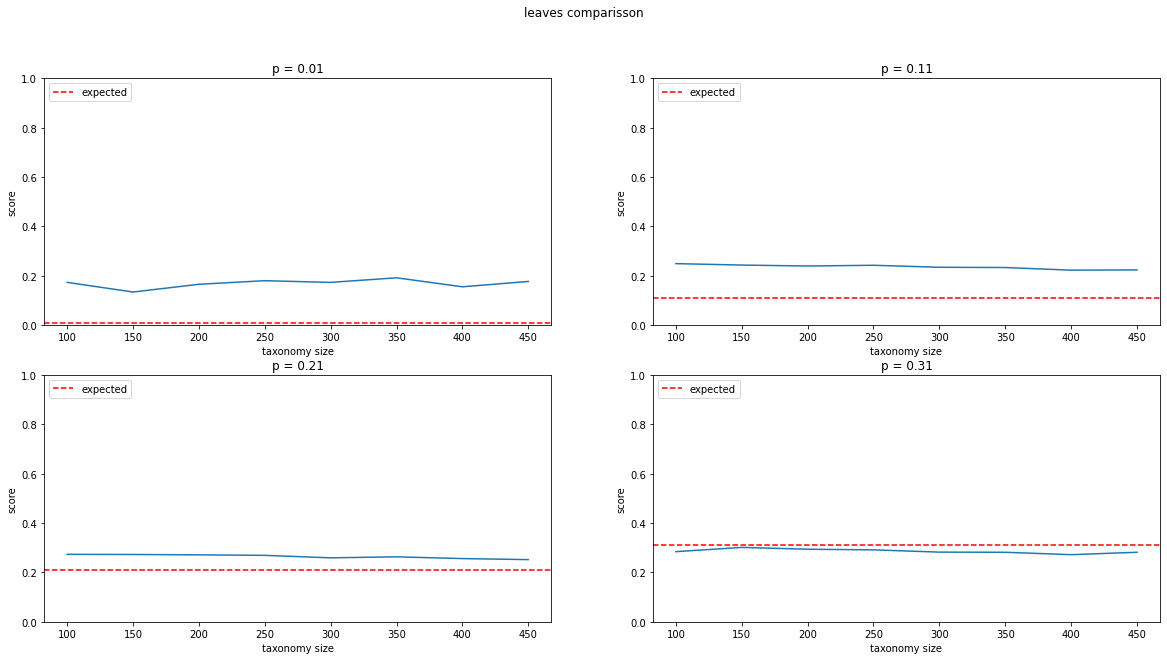

In [700]:
# show_scores(x, rows, cols, scores, p, title):
x = [i for i in range(100,500,50)]
p = [0.01 + i*0.1 for i in range(6)]
show_scores(x, 2, 2, [scores], p, 'leaves comparisson', figsize=(20,10))

## Расчеты расстояний, использующие loose mapping

In [713]:
def loose_mapping(tree1, tree2, feature='depth'):
    for node in tree1.traverse("preorder"):
        matched = tree2.search_nodes(name=node.name)
        if not matched:
            node.add_features(loose_map=node.up.loose_map)
        elif getattr(matched[0],feature) != getattr(node,feature):
            node.add_features(loose_map=node.up.loose_map)
        else:
            node.add_features(loose_map=matched[0])
            
def loose_mapping_dissimilarity_pct(tree1, tree2,feature='depth'):
    loose_mapping(tree1, tree2,feature)
    score = 0
    total = 0
    for node in tree1.traverse():
        score+=node.name == (node.loose_map).name and getattr(node,feature)==getattr(node.loose_map,feature)
        total+=1
        node.del_feature('loose_map')
    return 1- score/total
            
def loose_mapping_dissimilarity_score(tree1, tree2,feature='depth',debug=False):
    loose_mapping(tree1, tree2, feature)
    score = 0
    total = 0
    for node in tree1.traverse():
        score+=abs(getattr(node,feature)-getattr(node.loose_map,feature))
        total+=getattr(node,feature)+getattr(node.loose_map,feature)
        if debug:
            print(node.name, getattr(node,feature), '-----',node.loose_map.name,getattr(node.loose_map,feature))
        node.del_feature('loose_map')
    return score/total

In [714]:
scores_lm_depth_pct = get_dists(10,loose_mapping_dissimilarity_pct)
scores_lm_subtree_pct = get_dists(10,loose_mapping_dissimilarity_pct,'subtree_size')

p=1,average=[0.00649351 0.01226415 0.01219512 0.01066282 0.01197007] calculation time 10.555537939071655
p=11,average=[0.0538961  0.06792453 0.06236934 0.06368876 0.06134663] calculation time 11.324716091156006
p=21,average=[0.10454545 0.11037736 0.11254355 0.1129683  0.11396509] calculation time 10.686414003372192
p=31,average=[0.14415584 0.16132075 0.15853659 0.15648415 0.16882793] calculation time 11.246027946472168
p=41,average=[0.1961039  0.20235849 0.19965157 0.20489914 0.21770574] calculation time 10.450443029403687
p=51,average=[0.22857143 0.24386792 0.26376307 0.23458213 0.26034913] calculation time 11.534779071807861
p=1,average=[0.05472973 0.05066079 0.05212766 0.04795322 0.04024096] calculation time 12.197024822235107
p=11,average=[0.21013514 0.20881057 0.2035461  0.19766082 0.17879518] calculation time 11.256083011627197
p=21,average=[0.28378378 0.29955947 0.27198582 0.26637427 0.26674699] calculation time 10.737163066864014
p=31,average=[0.34527027 0.34669604 0.33156028 0

In [715]:
scores_lm_depth_ds = get_dists(10,loose_mapping_dissimilarity_score)
scores_lm_subtree_ds = get_dists(10,loose_mapping_dissimilarity_score,'subtree_size')

p=1,average=[0.00166667 0.0013471  0.00215145 0.00150746 0.00169614] calculation time 11.728246212005615
p=11,average=[0.0102053  0.00768268 0.01098156 0.01017937 0.01219137] calculation time 12.775591850280762
p=21,average=[0.01840201 0.01455293 0.02187974 0.01692614 0.02048667] calculation time 11.446172952651978
p=31,average=[0.02585116 0.0227373  0.03152757 0.02529101 0.03128475] calculation time 10.814350843429565
p=41,average=[0.03251162 0.02912492 0.03794069 0.03574572 0.04089733] calculation time 10.628241777420044
p=51,average=[0.04368739 0.03370859 0.04833622 0.0421875  0.05264537] calculation time 10.483838081359863
p=1,average=[0.29317448 0.38585058 0.59826063 0.7043322  0.70853891] calculation time 10.390795946121216
p=11,average=[0.64842656 0.78978488 0.84979617 0.8998314  0.90046218] calculation time 10.575515985488892
p=21,average=[0.75375723 0.85048153 0.87899236 0.90856087 0.92615029] calculation time 10.401908159255981
p=31,average=[0.75651156 0.8527039  0.89683531 0

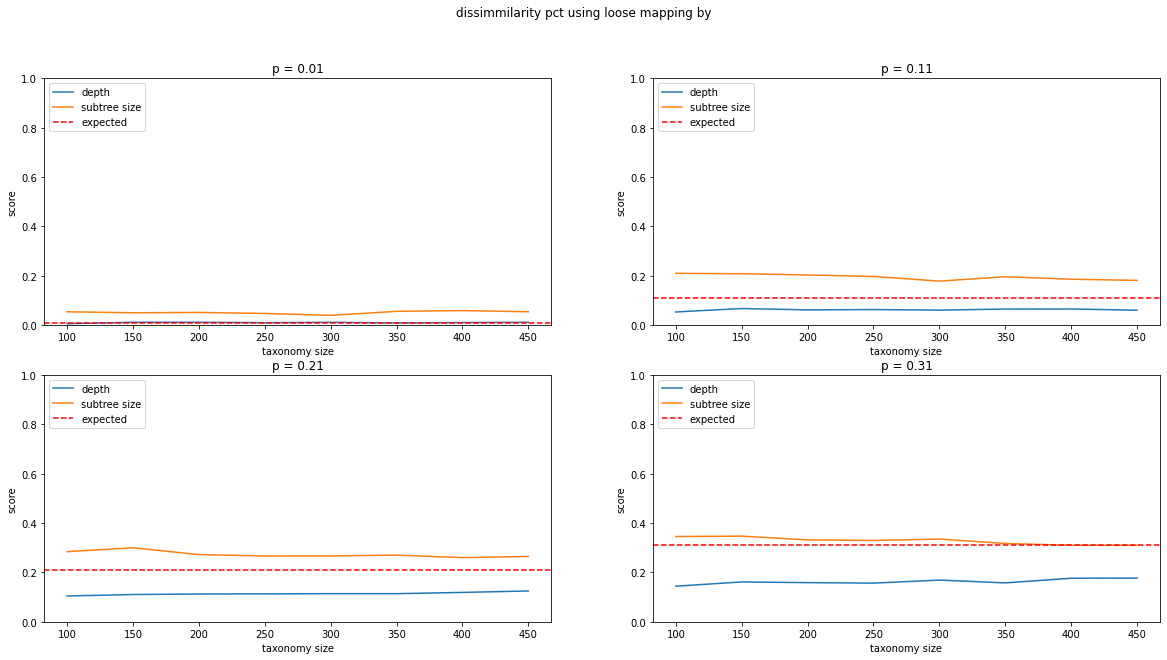

In [716]:
x = [i for i in range(100,500,50)]
p = [0.01 + i*0.1 for i in range(6)]
show_scores(x, 2, 2, [scores_lm_depth_pct, scores_lm_subtree_pct], p, 'dissimmilarity pct using loose mapping by', labels=['depth','subtree size'],figsize=(20,10))

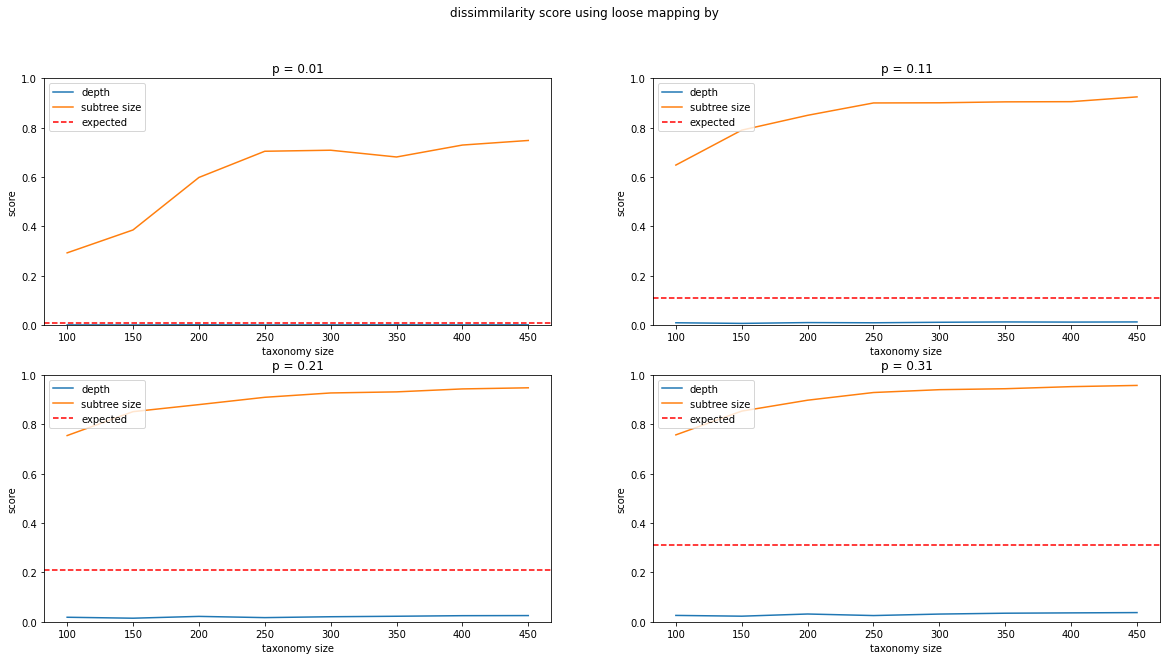

In [717]:
x = [i for i in range(100,500,50)]
p = [0.01 + i*0.1 for i in range(6)]
show_scores(x, 2, 2, [scores_lm_depth_ds, scores_lm_subtree_ds], p, 'dissimmilarity score using loose mapping by', labels=['depth','subtree size'],figsize=(20,10))

расстояния, посчитанные путем сравенния матриц расстояний между всеми вершинами

In [718]:
import numpy as np
with open('full_matrices_scores.npy', 'rb') as f:
    scores_ = np.load(f)

[[0.00904891 0.01746893 0.01866479 0.02341021 0.02263052 0.02337421
  0.0259702  0.02988776]
 [0.10360874 0.13500952 0.11920018 0.11428382 0.11276592 0.13240717
  0.11618794 0.1298039 ]
 [0.18449948 0.24942159 0.22055385 0.21038294 0.22020701 0.22225654
  0.20886364 0.23264332]
 [0.28760042 0.28860179 0.2941495  0.28823759 0.31101109 0.31308801
  0.30154559 0.31193939]
 [0.35520499 0.40981962 0.38685428 0.3620045  0.37690768 0.38124731
  0.3680354  0.39032476]]


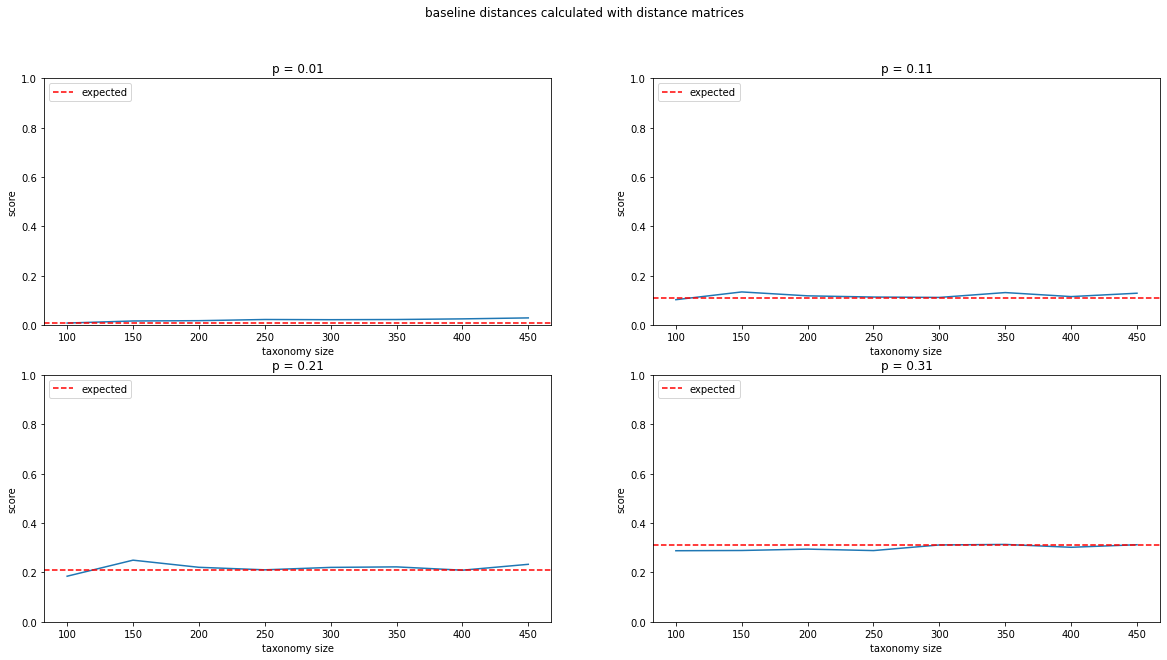

In [719]:
show_scores(x, 2, 2,[scores_], p,'baseline distances calculated with distance matrices',figsize=(20,10))